In [6]:
import nltk as nltk
import pandas as pd
import string
import re
import numpy as np
import matplotlib.pyplot as plt
import gensim

In [7]:
import pickle
import pandas as pd
import numpy
import re
import os
import numpy as np
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec

In [8]:
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import Counter
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [9]:
def load_dataframe(filename):
    return pd.read_csv(filename)

def tokenizeTweets(sentance):
    words = word_tokenize(sentance)
    noise_free_words = [word for word in words if word not in Stop_words]
    return noise_free_words


def cleanPunctuation(sentance):
    new_sentance = sentance.translate(str.maketrans('', '', string.punctuation))
    return new_sentance

def cleanLinks(sentance):
    sentance = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', sentance, flags=re.MULTILINE)
    return(sentance)

def stemming(wordsList):
    #getting the root of every word for all tweets
    rootList = []
    ps = PorterStemmer()
    for w in wordsList:
        #remove the 'Retweet' tag
        if (w != 'RT'):
            rootList.append(ps.stem(w))
    return rootList


def lemmataizeSentance(wordsList):
    #getting the root of every word for all tweets
    rootList = []
    wl = WordNetLemmatizer()
    for w in wordsList:
        #remove the 'Retweet' tag
        if (w != 'RT'):
            rootList.append(wl.lemmatize(w))
    return rootList


def chunking(wordsList):
    PartsOfSpeech = pos_tag(wordsList)
    Named_entities = ne_chunk(PartsOfSpeech)
    return Named_entities

def replace_empty_to_nan(sentance, dfm , index):
    if len(sentance) == 0 :
        dfm['text'][index] = float('NaN')        
    return dfm    


def remove_nan_rows(df):
    nan_value = float("NaN")
    df.replace("", nan_value, inplace=True)
    df.dropna(subset = ["text"], inplace=True)
    return df

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


def remove_unnecessary_data(dataframe):
    dfm = df_lemmatize = df_stem = df_chunk = dataframe.copy()
    
    #remove duplicate rows
    dfm = dfm.drop_duplicates(keep='first').copy() 
    
    #removing links,emoji's, punc and tokenzing the words and making 3 dfs in 3 methods
    for i in range(0, len(df.index)):
        temp = df['text'][i]
        temp = remove_emoji(temp)
        temp = cleanLinks(temp)
        temp = cleanPunctuation(temp)
        temp = tokenizeTweets(temp)
#         df_stem['text'][i] = stemming(temp)
        df_lemmatize['text'][i] = lemmataizeSentance(temp)
#         df_chunk['text'][i] = chunking(temp)
       
        df_stem = replace_empty_to_nan(temp ,df_stem, i)
        df_lemmatize = replace_empty_to_nan(temp ,df_lemmatize, i)
        df_chunk = replace_empty_to_nan(temp ,df_chunk, i)
    
#     df_stem =  remove_nan_rows(df_stem)    
    df_lemmatize =  remove_nan_rows(df_lemmatize)    
#     df_chunk =  remove_nan_rows(df_chunk)    
    
             
    return df_stem , df_lemmatize, df_chunk
    
    
#run phase 3 - Data Handling phase 

Stop_words = set (stopwords.words('English'))
df = load_dataframe('trumpTweets.csv')
df_lemmatize = remove_unnecessary_data(df)[1]


C:\Users\Matan\AppData\Local\Temp/ipykernel_11064/26248263.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lemmatize['text'][i] = lemmataizeSentance(temp)
C:\Users\Matan\AppData\Local\Temp/ipykernel_11064/26248263.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['text'][index] = float('NaN')


Number of texts processed: 55265


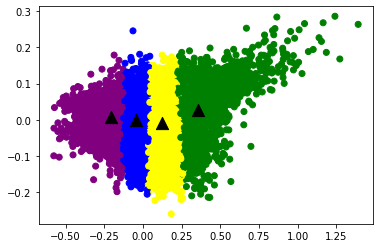

In [13]:
#Training the model & Generating the clusters - 4 Clusters

LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_train = []
j=0
for em in df_lemmatize['text'].values:
    all_content_train.append(LabeledSentence1(em,[j]))
    j+=1
print('Number of texts processed:' , j)


d2v_model = Doc2Vec(all_content_train, window = 10, min_count = 500, workers=7, dm = 1,alpha=0.025, min_alpha=0.001)
d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

kmeans_model = KMeans(n_clusters=4, init='k-means++', max_iter=100) 
X = kmeans_model.fit(d2v_model.dv.vectors)
labels=kmeans_model.labels_.tolist()
l = kmeans_model.fit_predict(d2v_model.dv.vectors)
pca = PCA(n_components=2).fit(d2v_model.dv.vectors)
datapoint = pca.transform(d2v_model.dv.vectors)
plt.figure
label1 = ['#FFFF00', '#008000', '#0000FF', '#800080']
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

Number of texts processed: 55265


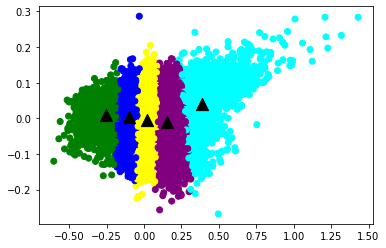

In [11]:
#Training the model & Generating the clusters - 5 Clusters

LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_train = []
j=0
for em in df_lemmatize['text'].values:
    all_content_train.append(LabeledSentence1(em,[j]))
    j+=1
print('Number of texts processed:' , j)


d2v_model = Doc2Vec(all_content_train, window = 10, min_count = 500, workers=7, dm = 1,alpha=0.025, min_alpha=0.001)
d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

kmeans_model = KMeans(n_clusters=5, init='k-means++', max_iter=100) 
X = kmeans_model.fit(d2v_model.dv.vectors)
labels=kmeans_model.labels_.tolist()
l = kmeans_model.fit_predict(d2v_model.dv.vectors)
pca = PCA(n_components=2).fit(d2v_model.dv.vectors)
datapoint = pca.transform(d2v_model.dv.vectors)
plt.figure
label1 = ['#FFFF00', '#008000', '#0000FF', '#800080','#00FFFF']
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

Number of texts processed: 55265


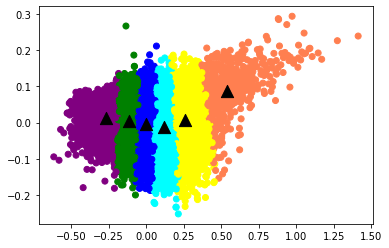

In [12]:
#Training the model & Generating the clusters - 6 Clusters

LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_train = []
j=0
for em in df_lemmatize['text'].values:
    all_content_train.append(LabeledSentence1(em,[j]))
    j+=1
print('Number of texts processed:' , j)


d2v_model = Doc2Vec(all_content_train, window = 10, min_count = 500, workers=7, dm = 1,alpha=0.025, min_alpha=0.001)
d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

kmeans_model = KMeans(n_clusters=6, init='k-means++', max_iter=100) 
X = kmeans_model.fit(d2v_model.dv.vectors)
labels=kmeans_model.labels_.tolist()
l = kmeans_model.fit_predict(d2v_model.dv.vectors)
pca = PCA(n_components=2).fit(d2v_model.dv.vectors)
datapoint = pca.transform(d2v_model.dv.vectors)
plt.figure
label1 = ['#FFFF00', '#008000', '#0000FF', '#800080','#00FFFF','#FF7F50']
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()
